# Задание 1. A/B–тестирование
#### Условие

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

---
#### Входные данные

- **groups.csv** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- **groups_add.csv** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- **active_studs.csv** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- **checks.csv** - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

---
#### Вопросы
- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?



In [1]:
import pandas as pd
import math
import numpy as np
import scipy.stats as st
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode
import json

In [2]:
# загрузка с яндекс диска
def load_file(path):
    public_key = path
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'  # noqa
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = json.loads(response.text)['href']
    return download_url

In [3]:
# загрузка с я.диска
# при нерабочем коде заменить load_file(path) на путь к файлу
path = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups = pd.read_csv(load_file(path), sep=';')

path = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
groups_add = pd.read_csv(load_file(path), sep=',')

path = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
active_studs = pd.read_csv(load_file(path), sep=',')

path = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
checks = pd.read_csv(load_file(path), sep=';')

In [4]:
# path = 'file_path'  # noqa
# groups = pd.read_csv(path, sep=';')

# path = 'file_path'  # noqa
# groups_add = pd.read_csv(path, sep=',')

# path = 'file_path'  # noqa
# active_studs = pd.read_csv(path, sep=',')

# path = 'file_path'  # noqa
# checks = pd.read_csv(path, sep=';')

**Основная метрика: CR(конверсия)**

**Второстепенная метрика: ARPPU, ARPU**


In [5]:
# основные статистики df
def test(df):
    print(f'Строки: {df.shape[0]}\t',
          f'Пропуски: {df.isna().sum()[0]}\t',
          f'Дубликаты: {df.duplicated().sum()}',
          '\n\nУникальные значения:\n', df.nunique(),
          '\n\nТип данных:\n', df.dtypes,
          sep='')

In [6]:
test(groups)

Строки: 74484	Пропуски: 0	Дубликаты: 0

Уникальные значения:
id     74484
grp        2
dtype: int64

Тип данных:
id      int64
grp    object
dtype: object


In [7]:
test(groups_add)

Строки: 92	Пропуски: 0	Дубликаты: 0

Уникальные значения:
id     92
grp     2
dtype: int64

Тип данных:
id      int64
grp    object
dtype: object


In [8]:
test(active_studs)

Строки: 8341	Пропуски: 0	Дубликаты: 0

Уникальные значения:
student_id    8341
dtype: int64

Тип данных:
student_id    int64
dtype: object


In [9]:
test(checks)

Строки: 541	Пропуски: 0	Дубликаты: 0

Уникальные значения:
student_id    541
rev            39
dtype: int64

Тип данных:
student_id      int64
rev           float64
dtype: object


In [10]:
groups.groupby('grp').count()

,id
grp,
A,14671
B,59813


In [11]:
# приводим название колонок к единому формату
active_studs = active_studs.rename(columns={'student_id': 'id'})
checks = checks.rename(columns={'student_id': 'id'})

Предположим, что файл __groups_add__ содержит данные для проведения А/В теста. Возможно по тех ошибке или другой причине данные пользователи не попали в основной файл, будем его учитывать в дальнейших расчетах.

In [12]:
# добавляем доп файл с пользователями
group_fix = groups.merge(groups_add, how='outer')

In [13]:
# активные пользователи в разбивке по группам
group_active = group_fix.merge(active_studs, how='right')

In [14]:
# покупки пользователей в разбивке по группам
group_check = group_fix.merge(checks, how='right')

In [15]:
group_active.merge(group_check, how='inner')

,id,grp,rev
0,1184303,A,1530.0000
1,3354191,B,1900.0001
2,3278734,B,1900.0000
3,720651,A,1980.0000
4,1232221,B,1900.0000
...,...,...,...
387,3890326,B,199.0000
388,1390994,A,398.0000
389,1516339,A,290.0000
390,3910596,B,597.0000


При объединии таблиц с платежами и активными пользователями можно увидеть, что остается только **392** строки, тогда как в таблице с оплатами было **541** значение. Это говорит о том, что оплата часть клиентов осуществляла оплату не заходя на платформу, проверим это предположение на данных

In [16]:
# оплаты при которых юзеры не заходили на платформу
checks.query('not id.isin(@active_studs.id)')

,id,rev
1,3185,690.0
2,25973,690.0
3,26280,690.0
5,100645,630.0
6,102534,580.0
...,...,...
508,5291900,199.0
512,5331842,290.0
521,5486319,199.0
530,5562806,398.0


Предположим, что у части пользователей предположительно стоит автоплатеж. Из этого следует, что в проведенном А/Б эксперименте они учавствовать не могут, поскольку данная группа пользователей осуществляла оплату в автоматическом режиме и не видела добавленных изменений.

Сформируем таблицу для дальнейшей работы

In [17]:
# соединение только активных юзеров и тех,
# кто из них производил оплату за время эксперимента
group_active_check = group_active.merge(group_check, how='left')

In [18]:
group_active_check

,id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN
...,...,...,...
8336,1794344,B,NaN
8337,296883,B,NaN
8338,3598448,B,NaN
8339,3610547,B,290.0


В файлах присутствует информация о пользователях и клиентах, а так же о совершении ими оплат.  
Поскольку нам не известно, что именно изменили для тестовой группы и на увеличение каких показателей это изменение направлено,то посчитаем основные метрики на их сновании будем примать дальнейшее решении об оценке различий между группами эксперимента.

<AxesSubplot:xlabel='rev', ylabel='Count'>

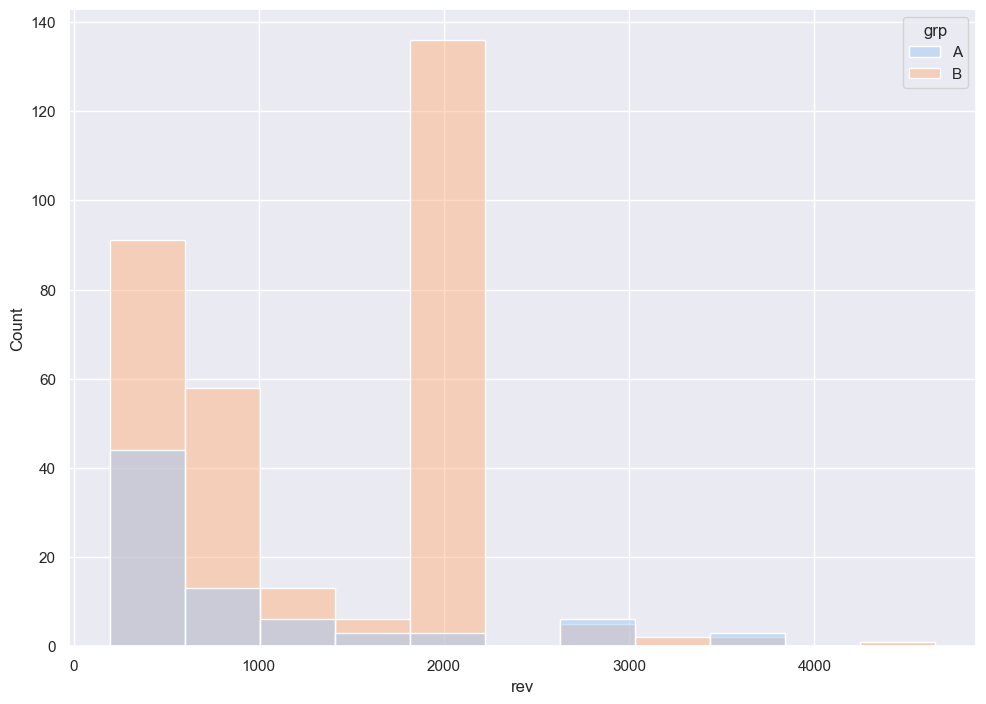

In [19]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.set_theme(palette='pastel')

sns.histplot(data=group_active_check, x="rev", hue='grp')

<AxesSubplot:xlabel='rev', ylabel='grp'>

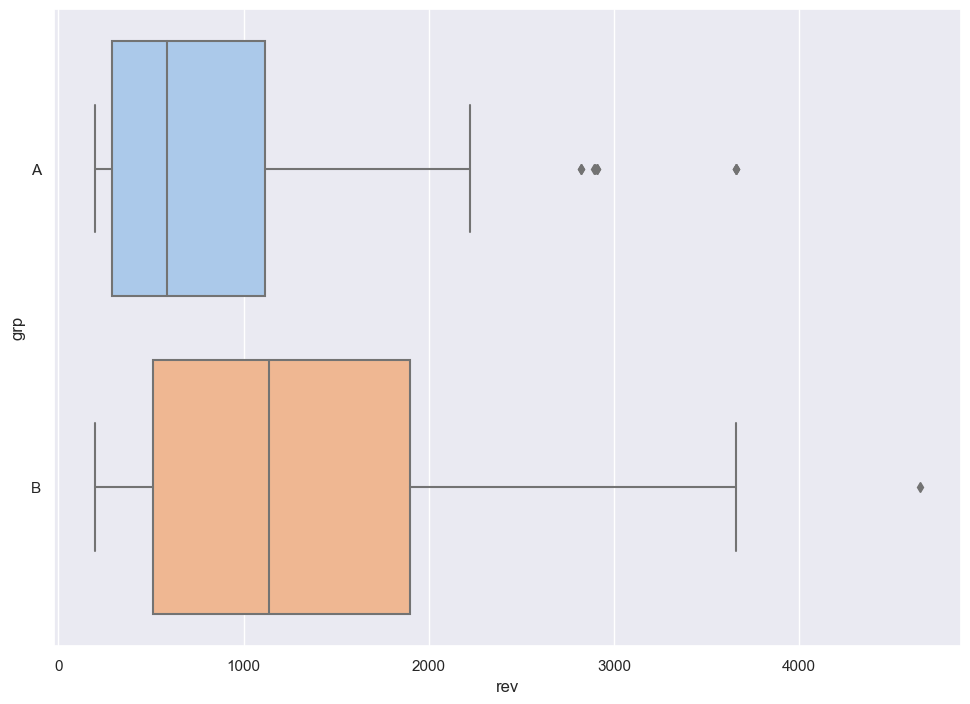

In [20]:
sns.boxplot(data=group_active_check, x="rev", y="grp")

In [21]:
# Проверка на нормальность распределения в группах
pg.normality(data=group_active_check, dv="rev",
             group="grp", method="normaltest")

,W,pval,normal
grp,,,
A,30.378420,2.531687e-07,False
B,6.795663,3.344572e-02,False


**По данным графикам можем наблюдать, что:**
- *распределения отличны от нормальных*
- *не унимодальны*
- *в 2х группах присутствуют выбросы*

In [22]:
# Метрики
client = group_active_check\
    .query('rev > 0')\
    .groupby('grp')\
    .id\
    .count()
users = group_active_check\
    .groupby('grp')\
    .id\
    .count()
offline_buy = group_active_check\
    .query('not id.isin(@active_studs.id)')\
    .groupby('grp')\
    .rev\
    .count()
revenue = group_active_check\
    .groupby('grp')\
    .rev\
    .sum()
mean = group_active_check\
    .groupby('grp')\
    .rev\
    .mean()

cr_to_buy = (client / users)
arppu = revenue / client
arpu = revenue / users

metrics = pd.DataFrame({'client': client,
                        'users': users,
                        'cr_to_buy': cr_to_buy,
                        'arppu': arppu,
                        'arpu': arpu})

In [23]:
metrics

,client,users,cr_to_buy,arppu,arpu
grp,,,,,
A,78,1538,0.050715,933.589744,47.347204
B,314,6803,0.046156,1257.878992,58.058798


Согласно посчитанным метрикам можно наблюдать, что:
- группы распределены неравномерно(6803 юзера в гр.В, потив 1538 в гр.А)
- показатель arppu в обеих группах равен ср. чеку, это означает, что на 1 пользователя приходится не более 1 оплаты
- конверсии в покупку на первый взгляд сильно не отличаюся
- arpu и arppu имеют сильное различие между группами
---
Так как критерии оценки нам не известны, считаю верным подходом сравнить все имеющиеся показатели.  
Для дальнейшей проверки формируем следующие гипотезы различий между группами:

**1. О различии в конверсии**  
**2. Различия в arppu(он же средний чек)**  
**3. Различия в arpu**  


### 1.   
Проверить различие конверсии в группах можно с помощью теста *хи-квадрат*. Для этого постороим таблицы сопреженности для дальнейшей передачи в функцию.
>H0 - конверсии между группами не отличаются
  
>H1 - конверсии между группами имет различия

In [24]:
# для кросс таблицы подготовим данные
# добавим столбец с оплатой и оплатой без захода в приложение
group_active_check['buy'] = group_active_check.rev.notna()

In [25]:
cr_buy = pd.crosstab(group_active_check.grp, group_active_check.buy)
cr_buy

buy,False,True
grp,,
A,1460,78
B,6489,314


In [26]:
pg.chi2_independence(group_active_check, x='grp', y='buy')

(buy        False        True
 grp                         
 A    1465.718979   72.281021
 B    6483.281021  319.718979,
 buy   False   True
 grp               
 A    1460.5   77.5
 B    6488.5  314.5,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  0.484808  1.0  0.486252  0.007624  0.107123
 1        cressie-read  0.666667  0.482018  1.0  0.487510  0.007602  0.106787
 2      log-likelihood  0.000000  0.476541  1.0  0.489993  0.007559  0.106127
 3       freeman-tukey -0.500000  0.472522  1.0  0.491829  0.007527  0.105643
 4  mod-log-likelihood -1.000000  0.468578  1.0  0.493642  0.007495  0.105168
 5              neyman -2.000000  0.460909  1.0  0.497200  0.007434  0.104245)

В расчетах хи-квадрат(для всех критериев) для обеих метрик значение *p-value(уровень значимости) выше установленного порога в 0,05*. Следовательно можно говорить о том, что **распределение конверсий по группам статзначимо не различается**.
  
Так же об этом свидетельствует коэф. крамера, при таких низких начениях (~0.0075) показывает слабую взаимосвязь между группами А и В.

### 2.   
Ранее мы определили, что согласно посчитаным метрикам ARPPU равен среднему чеку для 2х групп. Следовательно для простоты понимания будем проверять распределение на разницу средних.  
Получившиеся распределения не являются нормальными, поскольку мы имеем отностительно не большой размер выборки, использование *т-теста* не является валидным в данной ситуации. Интерпретация с помощью *критерия Манна-Уитни*(для ненормальных распределений) так же имеет существенные сложности.  

Осуществим сравление средних при помощи bootstrap'а.


<AxesSubplot:xlabel='rev', ylabel='Count'>

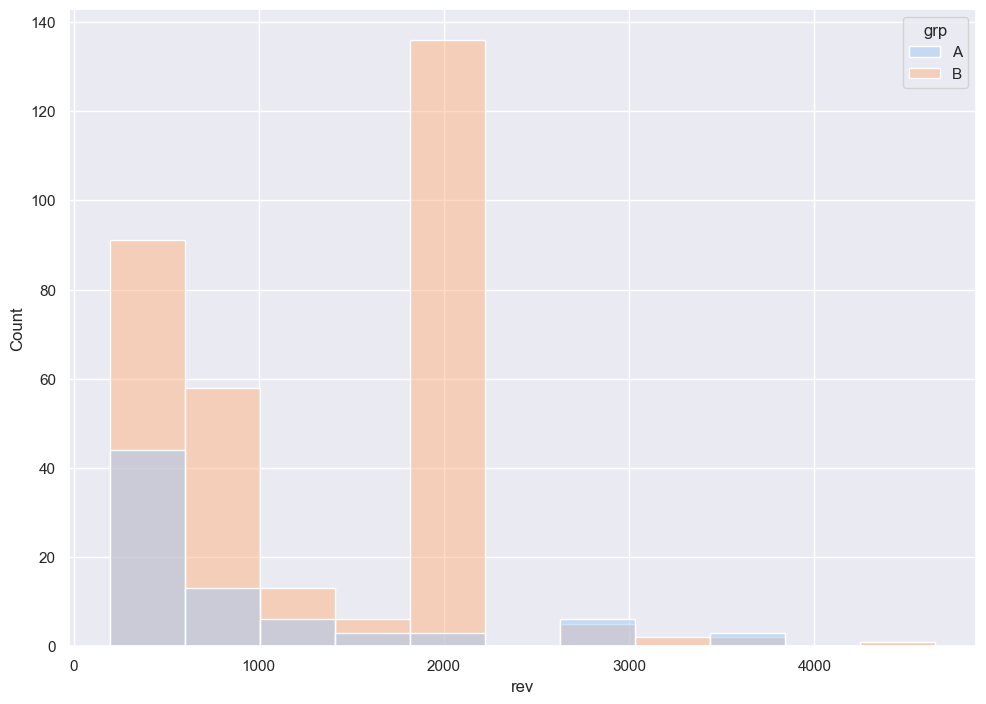

In [27]:
sns.histplot(group_active_check, x='rev', hue='grp')

In [28]:
# функции бутстрапа не работает с нулевыми знаениями, поэтому подготовим данные
group_a = group_active_check.query('grp == "A"').rev.dropna()
group_b = group_active_check.query('grp == "B"').rev.dropna()
# Строим распределения разницы средних через bootstrap
ci, array_rev = pg.compute_bootci(group_a, group_b,
                                  func=lambda a, b: np.mean(a) - np.mean(b),
                                  method='per', n_boot=10000, return_dist=True)
ci, array_rev

(array([-537.48,  -95.66]),
 array([-408.04990499, -311.09588205, -308.40618523, ..., -362.60094238,
        -257.11849882, -368.79324912]))

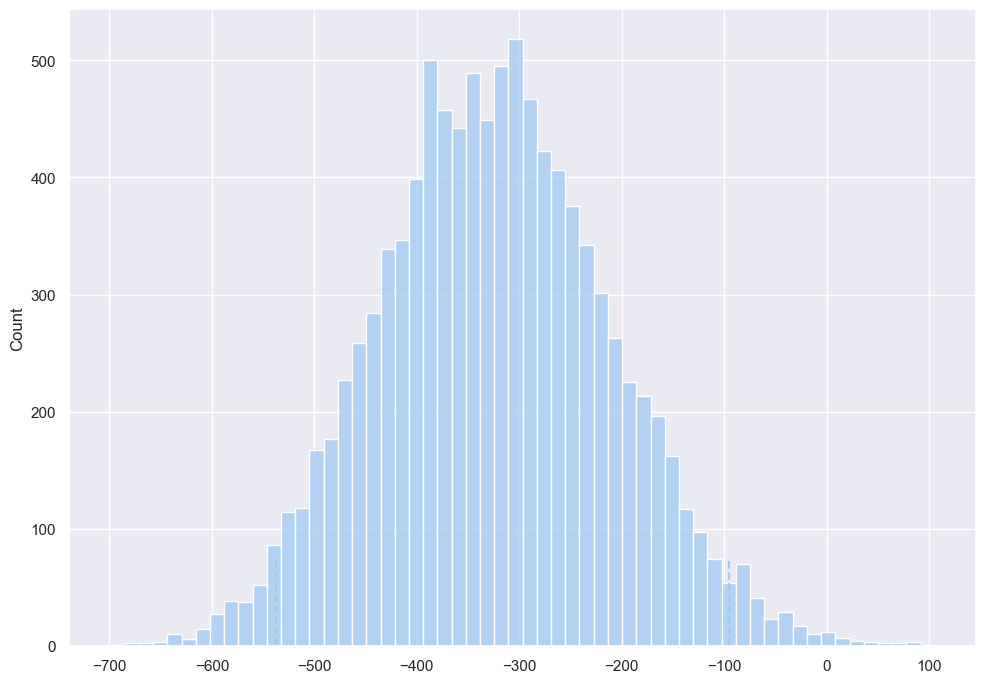

In [29]:
sns.histplot(array_rev)
plt.vlines(ci, ymin=0, ymax=75, linestyle='--')

Мы видим по графику и глядя доверительный интервал, что нулевое значение в него не попадает.  
Из этого следует, что cтатзначимо **среднее значение в контрольной группе меньше, чем в тестовой**.  

---
Показаталь ARPU проверять на статзначимость не имеет смысла, т.к. согласно формуле `ARPU=CR⋅ARPPU`, если у нас изменилось одно из значений, при неизменном втором результат будем похожий.  
А именно то, что мы **не смогли доказать различие в конверсии, а разница в средних(arppu) показача, что среднее значение выше в тестовой группе, а следовательно(для данного распределения) и ARPU так же будет выше**.

### Выводы по анализу данных и А/В тесту  
- анализ продуктовых метрик показал различие в arpu, arppu. В тестовой группе показатели превосходят контрольную
- cr визуально не имеет особых различий
- статзначимо доказано неравество arpu, arppu, а именно более высоких показателей в группе В(тестовой)
- статзначимых различий в cr не выявлено

---

Согласно проведенному анализу и тестам новая механика положительно повлияла на показатели оплат пользователей. Недостаток данных не позволил определить с чем именно связанно улучшение механики. В выборке тестовая группа статзначимо подтвердила более высокие показатели оплат без ярко выраженных снижений по конверсии.  
**Из всего выше перечисленного делаем вывод, что следует запускать новую механику оплат на всех пользователей**.  
Однако следует ознакомится со списком изменений, возможно потребуется запросить другие данные для проверки показателей связанных с изменением механики.**



# Задание 2. SQL

In [30]:
import pandahouse as ph

connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database': 'default',
                      'user': 'student',
                      'password': 'dpo_python_2020'}

# connection_test = dict(database='test',
#                   host='https://clickhouse.lab.karpov.courses',
#                   user='student-rw',
#                   password='656e2b0c9c'

## 1  
**Условие**

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

>Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.  

**Задача**  
Необходимо написать *оптимальный запрос*, который даст информацию о количестве очень усердных студентов.  
>NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [31]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    WITH
    (SELECT MAX(MONTH(timest)) FROM default.peas) as maxMonth

    SELECT COUNT(st_id) as hard_students
    FROM
        (
            SELECT st_id
            FROM default.peas
            WHERE MONTH(timest) = maxMonth
            GROUP BY st_id
            HAVING SUM(correct) >= 20
        ) as p_1
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
hard_students = ph.read_clickhouse(query=q, connection=connection_default)
hard_students

,hard_students
0,136


## 2  
**Условие**

Образовательная платформа предлагает пройти студентам курсы по модели *trial*: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

**Задача**  
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
- ARPU считается относительно всех пользователей, попавших в группы.

>Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.  

>Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [32]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    WITH
        -- количество покупок курса по математике
        sum(
            case
                when (money > 0 and subject = 'Math')
                then 1 else 0
            end
            ) as total_math_buys,
         -- количество пользователей
        COUNT(DISTINCT a.st_id) as total_users,
        -- количество активных клиентов
        COUNT(
            DISTINCT(
                case
                    when (active_user and money > 0)
                    then a.st_id
                end
                )
            ) as total_active_clients,
        -- количество клиентов
        COUNT(
            DISTINCT(
                case
                    when money > 0
                    then a.st_id
                    end)
            ) as total_clients,
        -- активные пользователи
        COUNT(
            DISTINCT(
                case
                    when active_user
                    then a.st_id
                end)) as active_users,
        -- активные пользователи по математике
        COUNT(
            DISTINCT(
                case
                    when active_math_user
                    then a.st_id
                end)
            ) as active_math_users

    SELECT
        a.test_grp as test_group,
        sum(money) / total_users as ARPU,
        sum(case when active_user then money end) / active_users as ARPAU,
        -- CR в покупку
        total_clients / total_users as CR_buy,
        -- СR активного пользователя в покупку
        total_active_clients / active_users as CR_active_buy,
        -- CR из активности по математике в покупку курса по математике
        total_math_buys / active_math_users as CR_active_math_buy_math
    FROM
        default.studs a
            LEFT JOIN default.final_project_check b
                ON a.st_id = b.st_id
            LEFT JOIN
            -- добавляем активных пользователей
            (
                SELECT
                    st_id,
                    (
                    case
                        when sum(correct) > 10
                        then 1 else 0
                    end
                    ) as active_user
                FROM
                    default.peas
                GROUP BY st_id
            ) as c
                ON a.st_id = c.st_id
            LEFT JOIN
            -- добавляем актвных пользователей по математике
            (
                SELECT
                    st_id,
                    (
                    case
                        when sum(correct) >= 2
                        then 1 else 0
                    end
                    ) as active_math_user
                FROM
                    default.peas
                WHERE subject = 'Math'
                GROUP BY st_id
            ) as d
                ON a.st_id = d.st_id
    GROUP BY test_grp
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
all_metrics = ph.read_clickhouse(query=q, connection=connection_default)
all_metrics

,test_group,ARPU,ARPAU,CR_buy,CR_active_buy,CR_active_math_buy_math
0,control,4540.983607,10393.700787,0.049180,0.110236,0.163265
1,pilot,11508.474576,29739.583333,0.108475,0.260417,0.380952


# Задание 3. Python  

**Задача**
- Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла *groups_add.csv* (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
- Реализуйте функцию, которая будет строить графики по получаемым метрикам.


In [33]:
def get_mertics():

    # загрузка с яндекса
    path = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
    groups_add = pd.read_csv(load_file(path), sep=',')

    # Переименовываем для стандартизированного формата
    groups_add\
        .rename(columns=({groups_add.columns[0]: 'id',
                          groups_add.columns[1]: 'grp'}),
                inplace=True)

    # добавляем доп файл с пользователями
    group_fix = groups.merge(groups_add, how='outer')

    # формируем ддата фрейм для расчетов

    # активные пользователи в разбивке по группам
    group_active = group_fix.merge(active_studs, how='right')
    # покупки пользователей в разбивке по группам
    group_check = group_fix.merge(checks, how='right')
    # соединение активных юзеров и их оплат в момент теста
    group_active_check = group_active.merge(group_check, how='left')

    client = group_active_check.query('rev > 0').groupby('grp').id.count()
    users = group_active_check.groupby('grp').id.count()
    revenue = group_active_check.groupby('grp').rev.sum()

    cr_to_buy = (client / users)
    mean = group_active_check.groupby('grp').rev.mean()
    arppu = revenue / client
    arpu = revenue / users

    metrics = pd.DataFrame({
        'cr_to_buy': cr_to_buy,
        'mean': mean,
        'arppu': arppu,
        'arpu': arpu
    }).reset_index()

    return metrics

In [34]:
def get_charts(metrics):
    # количество строк(с округлением в большую сторону)
    nrows = -1*(metrics.shape[1] - 1) // 2*-1
    # количество колонок
    ncols = 2
    # счетчик для нумерации графиков
    count = 1

    plt.figure(figsize=(15, nrows*7))
    # отрисовка графиков
    for column in metrics:
        if column == 'grp':
            continue
        plt.subplot(nrows, ncols, count)
        bar = sns.barplot(x='grp', y=column, data=metrics)
        bar.axes.set_title(column, fontsize=20)
        count += 1

In [35]:
get_mertics()

,grp,cr_to_buy,mean,arppu,arpu
0,A,0.050715,933.589744,933.589744,47.347204
1,B,0.046156,1257.878992,1257.878992,58.058798


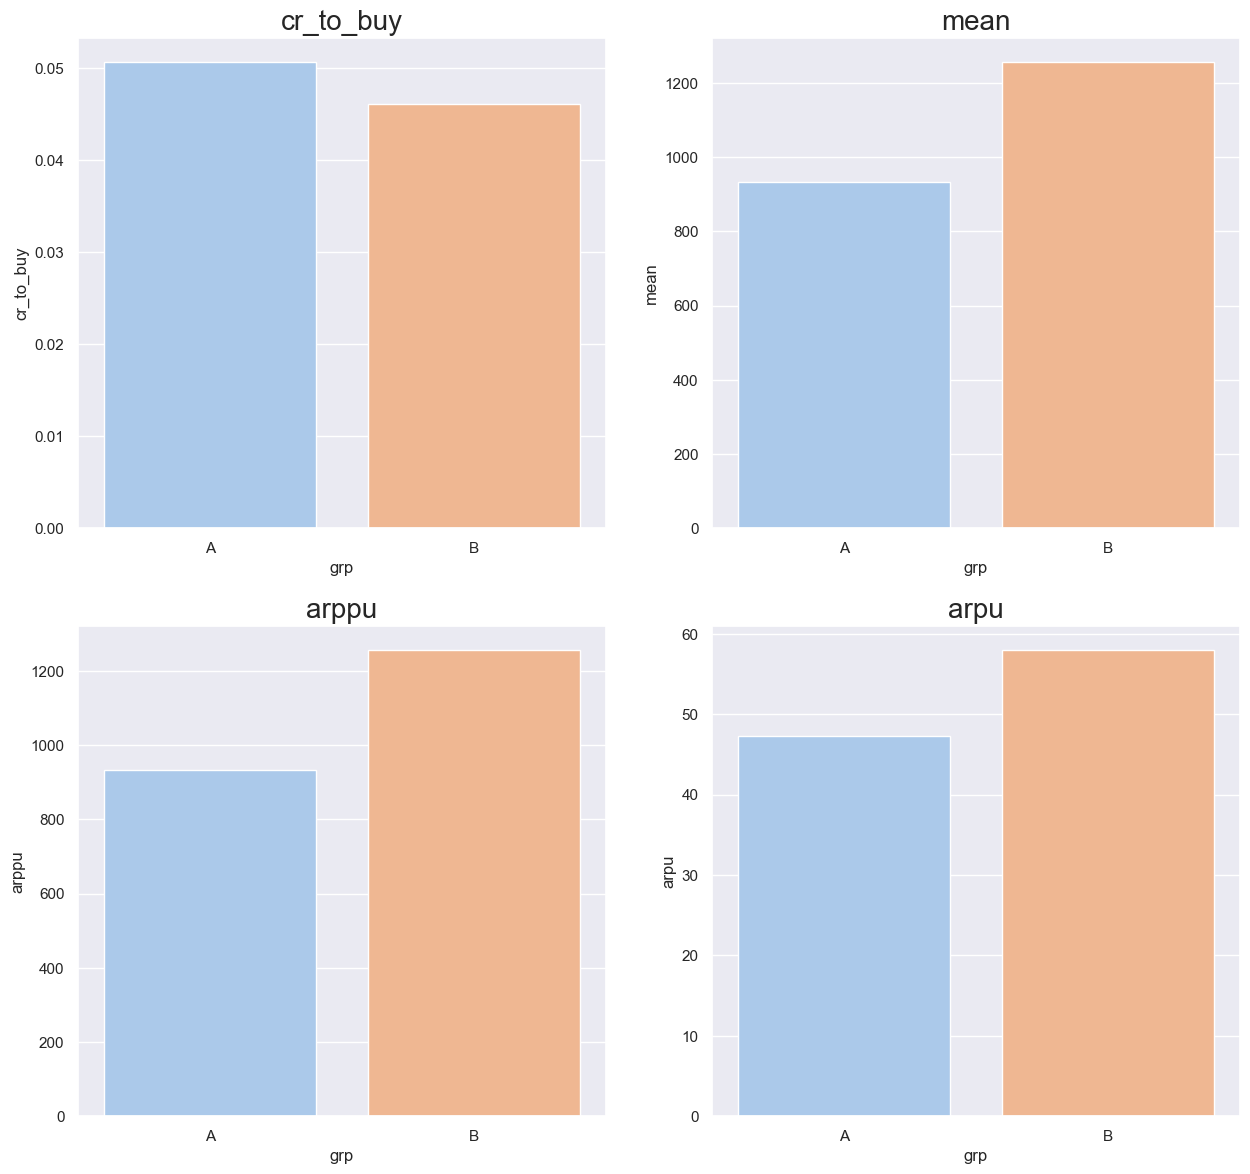

In [36]:
get_charts(get_mertics())